<a href="https://colab.research.google.com/github/plaban1981/Dphi_hackathon/blob/main/Identify_the_snake_breed.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Problem statement**

The government has been facing a long-standing issue of wild animals entering residential areas due to various reasons. It's of critical importance that if any such dangerous animal is encountered, the concerned authority should be notified immediately. Reptiles, especially snakes, are among the most dangerous animals and they often enter residential areas. 

Recently due to an incident of a youngster getting bitten by a snake, the government decided to install cameras at every corner of the road to detect snakes and other animals.

You have been hired as a Deep Learning engineer to create a sophisticated model that can detect the breed of a snake from its image.

The data folder consists of two folders and two .csv files. The details are as follows:

* train: Contains 5508 images for 35 classes 

* test: Contains 2361 images

* train.csv: 5508 x 2

* test.csv: 2361 x 1

In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


referrence : https://www.kaggle.com/rajatranjan/he-predict-auto-tag-image-using-fast-ai

https://www.kaggle.com/dskagglemt/snake-breed-classification-efficientnetb

https://www.kaggle.com/sghosh99/hackerearth-dl-challenge-rank-5-fast-ai

In [2]:
import numpy as np

import random, os

import cv2

import matplotlib.pyplot as plt 
import seaborn as sns
import matplotlib.image as mpimg
%matplotlib inline

import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.optimizers import Adam

In [3]:
from pathlib import Path
from fastai import *
from fastai.vision import *
import torch
from fastai.callbacks.hooks import *
from tqdm import tqdm_notebook
from PIL import Image

In [4]:
train = pd.read_csv("/content/drive/MyDrive/HackerEarth_deep_learning/snake_breed/train.csv")
test = pd.read_csv("/content/drive/MyDrive/HackerEarth_deep_learning/snake_breed/test.csv")

In [5]:
train.head()

image_id                   breed
0  a8b3ad1dde   nerodia-erythrogaster
1  8b492b973d   pantherophis-vulpinus
2  929b99ea92     thamnophis-sirtalis
3  bbac7385e2  pantherophis-obsoletus
4  ef776b1488  agkistrodon-contortrix

In [6]:
test.head()

image_id
0  7ede553357
1  3500b219e4
2  d43a78d6d9
3  1f36f26994
4  8cb85fc58e

In [7]:
train.shape,test.shape

((5508, 2), (2361, 1))

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


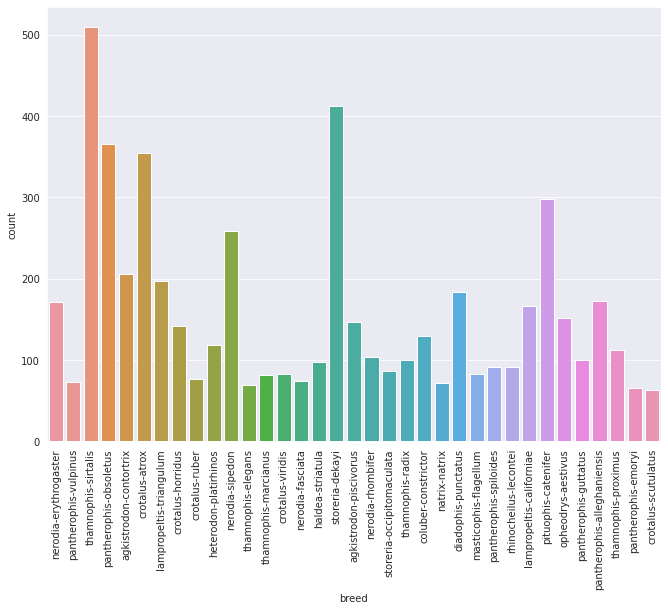

In [8]:
import seaborn as sns
sns.set_style('darkgrid')
plt.figure(figsize=(11,8))
plt.xticks(rotation=90)
sns.countplot(train['breed'])

In [8]:
train['image_id'] = train['image_id']+str('.jpg')
test['image_id'] = test['image_id']+str('.jpg')

In [9]:
train.head()

image_id                   breed
0  a8b3ad1dde.jpg   nerodia-erythrogaster
1  8b492b973d.jpg   pantherophis-vulpinus
2  929b99ea92.jpg     thamnophis-sirtalis
3  bbac7385e2.jpg  pantherophis-obsoletus
4  ef776b1488.jpg  agkistrodon-contortrix

In [11]:
train[train['image_id'] =="f7a26d3312.jpg"]

image_id                breed
31  f7a26d3312.jpg  coluber-constrictor

In [12]:
train.shape,test.shape

((5508, 2), (2361, 1))

In [ ]:
import cv2
from google.colab.patches import cv2_imshow
img = cv2.imread("/content/drive/MyDrive/HackerEarth_deep_learning/snake_breed/train/f7a26d3312.jpg",cv2.COLOR_BGR2RGB)
# get dimensions of image
dimensions = img.shape
 
# height, width, number of channels in image
height = img.shape[0]
width = img.shape[1]
channels = img.shape[2]
 
print('Image Dimension    : ',dimensions)
print('Image Height       : ',height)
print('Image Width        : ',width)
print('Number of Channels : ',channels)

Image Dimension    :  (96, 128, 3)
Image Height       :  96
Image Width        :  128
Number of Channels :  3


#### **random Train images**

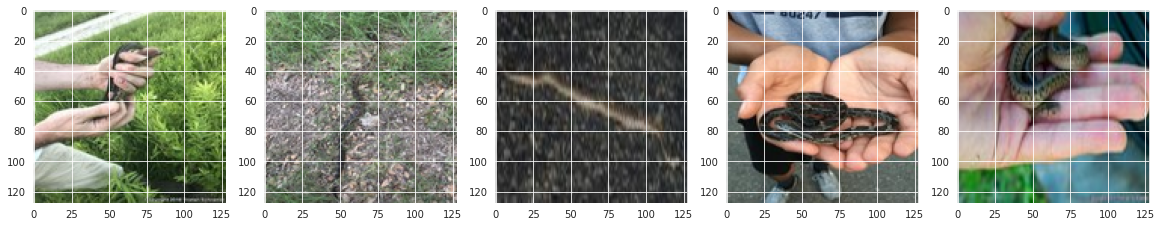

In [ ]:
plt.figure(figsize = (20, 12))
images_ = os.listdir("/content/drive/MyDrive/HackerEarth_deep_learning/snake_breed/train")
for i , image_index in enumerate(np.random.randint(len(os.listdir("/content/drive/MyDrive/HackerEarth_deep_learning/snake_breed/train")),size=5)):
  plt.subplot(1,5,i  + 1)
  img = cv2.imread('/content/drive/MyDrive/HackerEarth_deep_learning/snake_breed/train/'+images_[image_index])
  img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
  img = Image.fromarray(img)
  img = img.resize((128,128))
  plt.imshow(np.array(img))

#### **random test images**

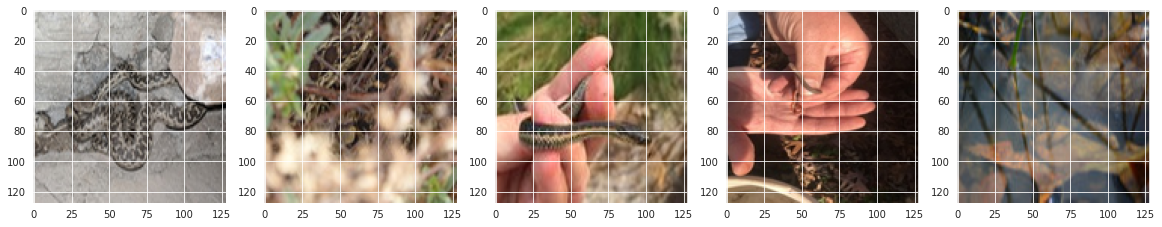

In [ ]:
plt.figure(figsize = (20, 12))
images_ = os.listdir("/content/drive/MyDrive/HackerEarth_deep_learning/snake_breed/test")
for i , image_index in enumerate(np.random.randint(len(os.listdir("/content/drive/MyDrive/HackerEarth_deep_learning/snake_breed/test")),size=5)):
  plt.subplot(1,5,i  + 1)
  img = cv2.imread('/content/drive/MyDrive/HackerEarth_deep_learning/snake_breed/test/'+images_[image_index])
  img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
  img = Image.fromarray(img)
  img = img.resize((128,128))
  plt.imshow(np.array(img))

In [ ]:
from google.colab.patches import cv2_imshow
def plot_3_images_by_labels(label):
  image_path = "/content/drive/MyDrive/HackerEarth_deep_learning/snake_breed/train/"
  images_names = train[train['breed']== label]['image_id'].tolist()[:5]
  for i, img_name in enumerate(images_names):
    pic = image_path+img_name
    image = cv2.imread(pic,cv2.COLOR_BGR2RGB)
    image = cv2.putText(image,label,(5,25),cv2.FONT_HERSHEY_SIMPLEX,0.55,(0,255,0),2)
    image = cv2.resize(image,(256,256))
    cv2_imshow(image)

In [ ]:
import random
labels = train['breed'].unique()
idx = random.randint(0,len(labels))
label = labels[idx]
print(label)


lampropeltis-californiae


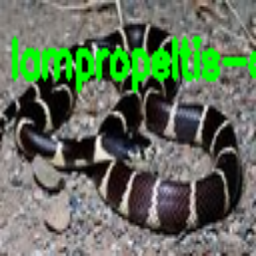

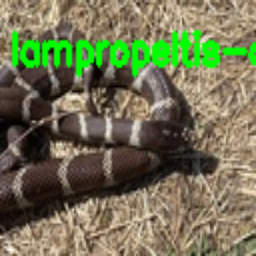

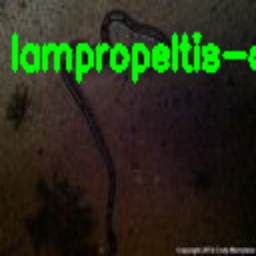

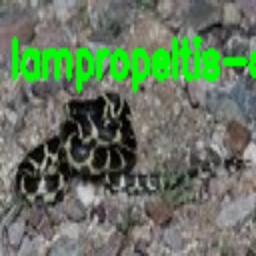

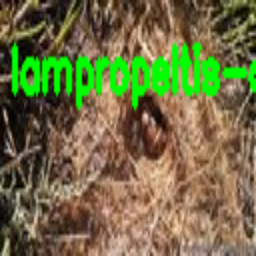

In [ ]:
plot_3_images_by_labels(label)

**Fastai + Efficientnet**

In [9]:
!pip install -q efficientnet_pytorch

In [10]:
from efficientnet_pytorch import EfficientNet
from torch.utils import model_zoo
from fastai.callbacks import *
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [11]:
import warnings
warnings.filterwarnings("ignore")

In [12]:
def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
seed_everything()

In [ ]:
print('Make sure cuda is installed:', torch.cuda.is_available())
print('Make sure cudnn is enabled:', torch.backends.cudnn.enabled)

Make sure cuda is installed: True
Make sure cudnn is enabled: True


In [13]:
hack_path = "/content/drive/MyDrive/HackerEarth_deep_learning/snake_breed"
train_path = "/content/drive/MyDrive/HackerEarth_deep_learning/snake_breed/train"
test_path = "/content/drive/MyDrive/HackerEarth_deep_learning/snake_breed/test"
def get_data(bs, size):
    data = ImageDataBunch.from_df(df=train, path=train_path,
                                  bs=bs, size=size, valid_pct=0.1, 
                                  resize_method=ResizeMethod.SQUISH, 
                                  ds_tfms=get_transforms(max_lighting=0.4, max_zoom=1.2, 
                                                         max_warp=0.2, max_rotate=20, 
                                                         xtra_tfms=[flip_lr()]))
    test_data = ImageList.from_df(test, path=test_path)
    data.add_test(test_data)
    data.normalize(imagenet_stats)
    return data

In [14]:
data = get_data(bs=32, size=224)

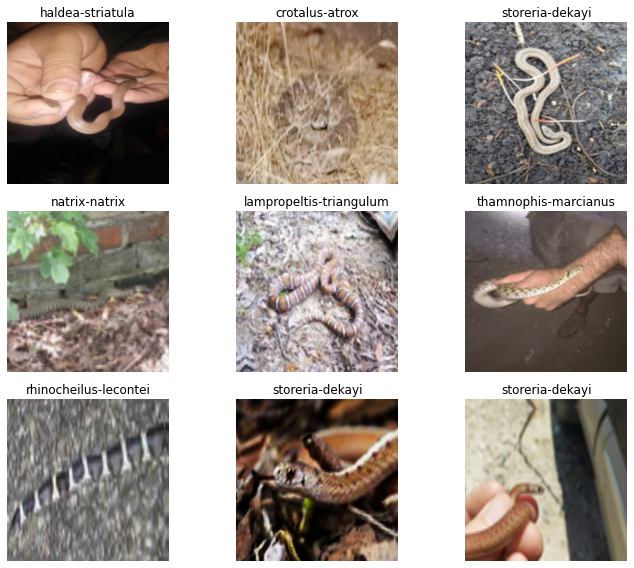

In [15]:
data.show_batch(rows=3, figsize=(10,8))

In [16]:
data.c

35

In [17]:
model_name = 'efficientnet-b3'
def get_model(pretrained=True, **kwargs):
    model = EfficientNet.from_pretrained(model_name)
    model._fc = nn.Linear(model._fc.in_features, data.c)
    return model

In [18]:
learn = Learner(data, get_model(), 
                metrics=[FBeta(), accuracy],
                callback_fns=[partial(SaveModelCallback),ShowGraph],
                wd=0.1,
                path = '/content/drive/MyDrive/HackerEarth').mixup()

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b3-5fb5a3c3.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b3-5fb5a3c3.pth



Loaded pretrained weights for efficientnet-b3


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 3.63E-03
Min loss divided by 10: 4.37E-04


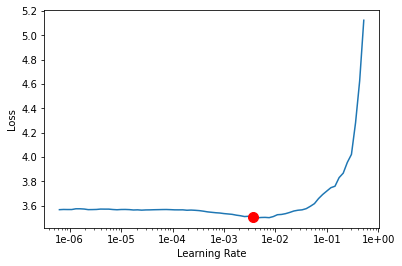

In [19]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [20]:
min_grad_lr = learn.recorder.min_grad_lr
min_grad_lr

0.00363078054770101

Better model found at epoch 0 with valid_loss value: 2.64609694480896.


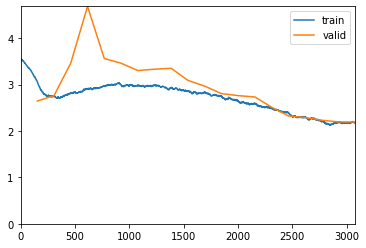

Better model found at epoch 14 with valid_loss value: 2.512470245361328.
Better model found at epoch 15 with valid_loss value: 2.3254804611206055.
Better model found at epoch 16 with valid_loss value: 2.2901742458343506.
Better model found at epoch 17 with valid_loss value: 2.23185396194458.
Better model found at epoch 18 with valid_loss value: 2.1961581707000732.
Better model found at epoch 19 with valid_loss value: 2.1945531368255615.


In [21]:
learn.fit_one_cycle(20, min_grad_lr)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 3.98E-06
Min loss divided by 10: 1.00E-04


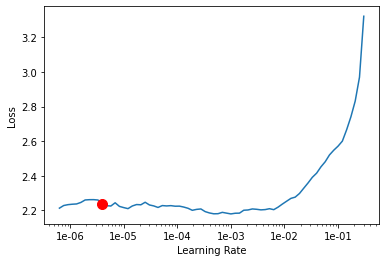

In [22]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [23]:
min_grad_lr = learn.recorder.min_grad_lr
min_grad_lr

3.981071705534973e-06

Better model found at epoch 0 with valid_loss value: 2.1987597942352295.


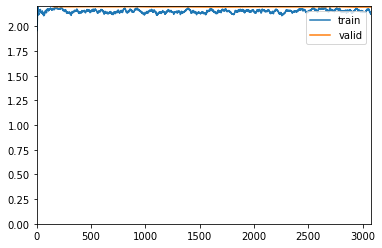

Better model found at epoch 1 with valid_loss value: 2.197740077972412.
Better model found at epoch 6 with valid_loss value: 2.1959564685821533.
Better model found at epoch 9 with valid_loss value: 2.1956872940063477.
Better model found at epoch 10 with valid_loss value: 2.194915771484375.
Better model found at epoch 18 with valid_loss value: 2.1944494247436523.


In [24]:
learn.fit_one_cycle(20, slice(min_grad_lr))

In [25]:
unfrozen_validation = learn.validate()
print("Final model validation loss: {0}".format(unfrozen_validation[0]))

Final model validation loss: 2.1944494247436523


In [26]:
learn.save('efficientnet-unfrozen', return_path=True)

PosixPath('/content/drive/MyDrive/HackerEarth/models/efficientnet-unfrozen.pth')

In [27]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

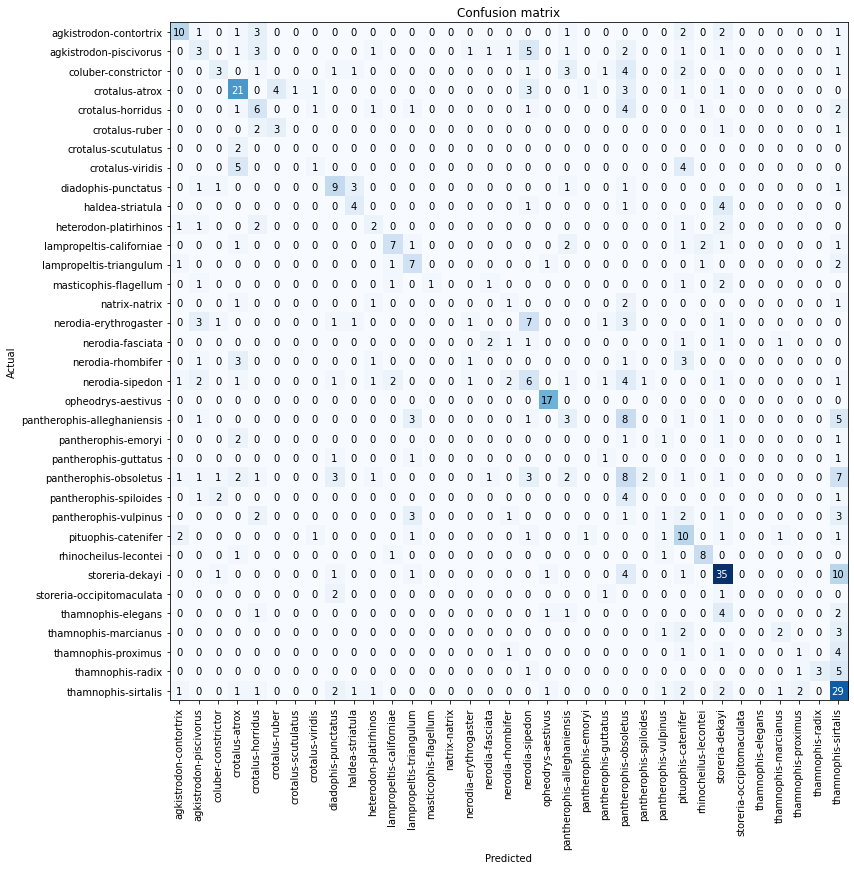

In [28]:
interp.plot_confusion_matrix(figsize=(12,12))

In [29]:
interp.most_confused(min_val=2)

[('storeria-dekayi', 'thamnophis-sirtalis', 10),
 ('pantherophis-alleghaniensis', 'pantherophis-obsoletus', 8),
 ('nerodia-erythrogaster', 'nerodia-sipedon', 7),
 ('pantherophis-obsoletus', 'thamnophis-sirtalis', 7),
 ('agkistrodon-piscivorus', 'nerodia-sipedon', 5),
 ('crotalus-viridis', 'crotalus-atrox', 5),
 ('pantherophis-alleghaniensis', 'thamnophis-sirtalis', 5),
 ('thamnophis-radix', 'thamnophis-sirtalis', 5),
 ('coluber-constrictor', 'pantherophis-obsoletus', 4),
 ('crotalus-atrox', 'crotalus-ruber', 4),
 ('crotalus-horridus', 'pantherophis-obsoletus', 4),
 ('crotalus-viridis', 'pituophis-catenifer', 4),
 ('haldea-striatula', 'storeria-dekayi', 4),
 ('nerodia-sipedon', 'pantherophis-obsoletus', 4),
 ('pantherophis-spiloides', 'pantherophis-obsoletus', 4),
 ('storeria-dekayi', 'pantherophis-obsoletus', 4),
 ('thamnophis-elegans', 'storeria-dekayi', 4),
 ('thamnophis-proximus', 'thamnophis-sirtalis', 4),
 ('agkistrodon-contortrix', 'crotalus-horridus', 3),
 ('agkistrodon-piscivor

In [30]:
probability, classification = learn.TTA(ds_type=DatasetType.Test)

In [33]:
predictions = probability.argmax(dim=1)

In [40]:
np.array(predictions)

array([18, 28,  4, 28, ..., 23, 27,  4, 20])

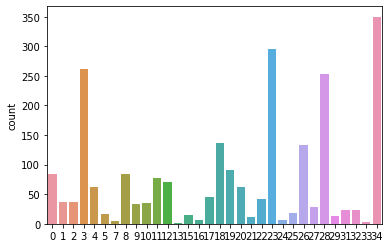

In [41]:
sns.countplot(np.array(predictions))

In [47]:
data.classes[34]

'thamnophis-sirtalis'

In [43]:
breed = []
for item in np.array(predictions):
  breed.append(data.classes[item])

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27,
        28, 29, 30, 31]), <a list of 32 Text major ticklabel objects>)

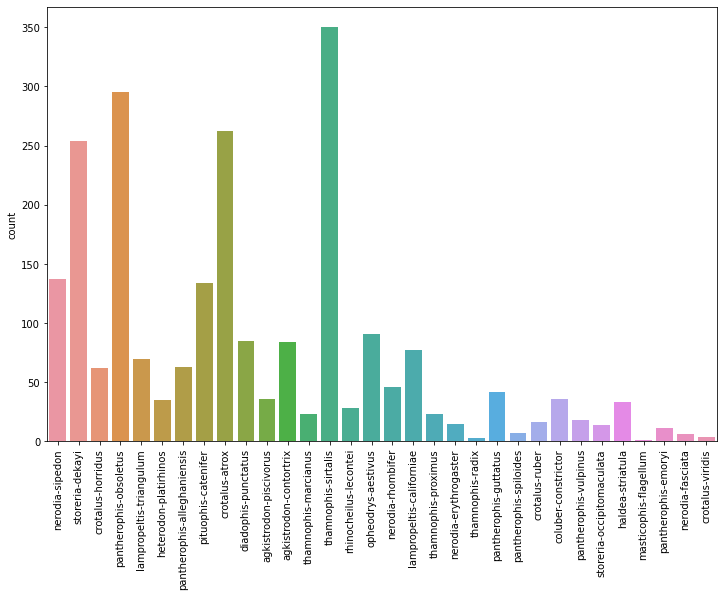

In [45]:
plt.figure(figsize=(12,8))
sns.countplot(breed)
plt.xticks(rotation=90)

In [46]:
data.classes[0],data.classes[1]

('agkistrodon-contortrix', 'agkistrodon-piscivorus')

In [34]:
(probability.argmax(dim=1) + 1).unique()

tensor([ 1,  2,  3,  4,  5,  6,  8,  9, 10, 11, 12, 13, 14, 16, 17, 18, 19, 20,
        21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 32, 33, 34, 35])

In [57]:
test['breed'] = probability.argmax(dim=1) + 1

In [58]:
test.head()

image_id  breed
0  7ede553357.jpg     19
1  3500b219e4.jpg     29
2  d43a78d6d9.jpg      5
3  1f36f26994.jpg     29
4  8cb85fc58e.jpg     24

In [64]:
test.breed.min()

1

In [61]:
name_dict = {}
for i,j in  enumerate(data.classes):
  name_dict[i+1] = j

In [62]:
name_dict 

{1: 'agkistrodon-contortrix',
 2: 'agkistrodon-piscivorus',
 3: 'coluber-constrictor',
 4: 'crotalus-atrox',
 5: 'crotalus-horridus',
 6: 'crotalus-ruber',
 7: 'crotalus-scutulatus',
 8: 'crotalus-viridis',
 9: 'diadophis-punctatus',
 10: 'haldea-striatula',
 11: 'heterodon-platirhinos',
 12: 'lampropeltis-californiae',
 13: 'lampropeltis-triangulum',
 14: 'masticophis-flagellum',
 15: 'natrix-natrix',
 16: 'nerodia-erythrogaster',
 17: 'nerodia-fasciata',
 18: 'nerodia-rhombifer',
 19: 'nerodia-sipedon',
 20: 'opheodrys-aestivus',
 21: 'pantherophis-alleghaniensis',
 22: 'pantherophis-emoryi',
 23: 'pantherophis-guttatus',
 24: 'pantherophis-obsoletus',
 25: 'pantherophis-spiloides',
 26: 'pantherophis-vulpinus',
 27: 'pituophis-catenifer',
 28: 'rhinocheilus-lecontei',
 29: 'storeria-dekayi',
 30: 'storeria-occipitomaculata',
 31: 'thamnophis-elegans',
 32: 'thamnophis-marcianus',
 33: 'thamnophis-proximus',
 34: 'thamnophis-radix',
 35: 'thamnophis-sirtalis'}

In [65]:
test['label'] = test['breed'].map(name_dict)

In [66]:
test.head()

image_id  breed                   label
0  7ede553357.jpg     19         nerodia-sipedon
1  3500b219e4.jpg     29         storeria-dekayi
2  d43a78d6d9.jpg      5       crotalus-horridus
3  1f36f26994.jpg     29         storeria-dekayi
4  8cb85fc58e.jpg     24  pantherophis-obsoletus

In [67]:
test.breed.value_counts(normalize=True)

35    0.148242
24    0.124947
4     0.110970
29    0.107582
19    0.058026
27    0.056756
20    0.038543
9     0.036002
1     0.035578
12    0.032613
13    0.029648
21    0.026684
5     0.026260
18    0.019483
23    0.017789
2     0.015248
3     0.015248
11    0.014824
10    0.013977
28    0.011859
33    0.009742
32    0.009742
26    0.007624
6     0.006777
16    0.006353
30    0.005930
22    0.004659
25    0.002965
17    0.002541
8     0.001694
34    0.001271
14    0.000424
Name: breed, dtype: float64

In [68]:
test.label.value_counts(normalize=True)

thamnophis-sirtalis            0.148242
pantherophis-obsoletus         0.124947
crotalus-atrox                 0.110970
storeria-dekayi                0.107582
nerodia-sipedon                0.058026
pituophis-catenifer            0.056756
opheodrys-aestivus             0.038543
diadophis-punctatus            0.036002
agkistrodon-contortrix         0.035578
lampropeltis-californiae       0.032613
lampropeltis-triangulum        0.029648
pantherophis-alleghaniensis    0.026684
crotalus-horridus              0.026260
nerodia-rhombifer              0.019483
pantherophis-guttatus          0.017789
coluber-constrictor            0.015248
agkistrodon-piscivorus         0.015248
heterodon-platirhinos          0.014824
haldea-striatula               0.013977
rhinocheilus-lecontei          0.011859
thamnophis-proximus            0.009742
thamnophis-marcianus           0.009742
pantherophis-vulpinus          0.007624
crotalus-ruber                 0.006777
nerodia-erythrogaster          0.006353


In [69]:
df = test[['image_id','label']].copy()

In [75]:
def remove_jpg(x):
  return x.split(".")[0]

In [70]:
df = df.rename(columns ={'label':'breed'})

In [76]:
df['image_id'] = df['image_id'].apply(lambda x : remove_jpg(x))

In [77]:
df.isnull().sum()

image_id    0
breed       0
dtype: int64

In [78]:
df.shape

(2361, 2)

In [79]:
df.head()

image_id                   breed
0  7ede553357         nerodia-sipedon
1  3500b219e4         storeria-dekayi
2  d43a78d6d9       crotalus-horridus
3  1f36f26994         storeria-dekayi
4  8cb85fc58e  pantherophis-obsoletus

In [80]:
df.to_csv("efficienet3sub.csv",index=False)

In [55]:


df.to_csv('efficientnetb3.csv', index=False)

In [53]:
test.shape

(2361, 1)

**end of efficient network**

In [125]:
#using Label encoder to encode the training labes into numeric
from sklearn.preprocessing import LabelEncoder
le =LabelEncoder()
training_labels=le.fit_transform(train['breed'])

In [126]:
training_labels

array([15, 25, 34, 23, ..., 20, 34, 26, 12])

In [10]:
##transformations to be done to images
tfms = get_transforms(do_flip=True,flip_vert=False ,max_rotate=20.0, max_zoom=1.3, max_lighting=0.5, max_warp=0.1, p_affine=0.2,
                      p_lighting=0.55)
#, xtra_tfms=zoom_crop(scale=(0.9,1.8), do_rand=True, p=0.8))
data_folder = "/content/drive/MyDrive/HackerEarth_deep_learning/snake_breed"
## create databunch of test set to be passed
test_img = ImageList.from_df(test, path=data_folder, folder='test')

In [11]:
np.random.seed(145)
## create source of train image databunch
src = (ImageList.from_df(train, path=data_folder, folder='train')
       .split_by_rand_pct(0.10)
       #.split_none()
       .label_from_df()
       .add_test(test_img))

In [12]:
data = (src.transform(tfms, size=224,padding_mode='reflection',resize_method=ResizeMethod.SQUISH)
        .databunch(path='.', bs=64, device= torch.device('cuda:0')).normalize(imagenet_stats))

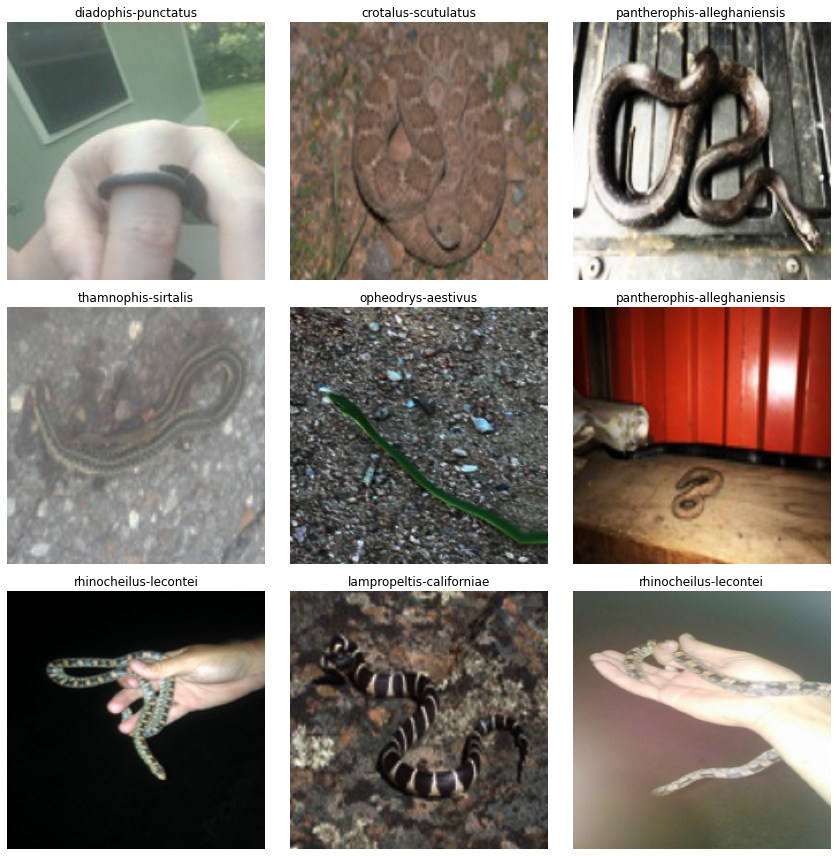

In [13]:
data.show_batch(rows=3, figsize=(12,12))

In [17]:
data.c,data.classes

(35,
 ['agkistrodon-contortrix',
  'agkistrodon-piscivorus',
  'coluber-constrictor',
  'crotalus-atrox',
  'crotalus-horridus',
  'crotalus-ruber',
  'crotalus-scutulatus',
  'crotalus-viridis',
  'diadophis-punctatus',
  'haldea-striatula',
  'heterodon-platirhinos',
  'lampropeltis-californiae',
  'lampropeltis-triangulum',
  'masticophis-flagellum',
  'natrix-natrix',
  'nerodia-erythrogaster',
  'nerodia-fasciata',
  'nerodia-rhombifer',
  'nerodia-sipedon',
  'opheodrys-aestivus',
  'pantherophis-alleghaniensis',
  'pantherophis-emoryi',
  'pantherophis-guttatus',
  'pantherophis-obsoletus',
  'pantherophis-spiloides',
  'pantherophis-vulpinus',
  'pituophis-catenifer',
  'rhinocheilus-lecontei',
  'storeria-dekayi',
  'storeria-occipitomaculata',
  'thamnophis-elegans',
  'thamnophis-marcianus',
  'thamnophis-proximus',
  'thamnophis-radix',
  'thamnophis-sirtalis'])

In [14]:
learn = cnn_learner(data=data, base_arch=models.resnet101, metrics=[FBeta(beta=1, average='macro'), accuracy],
                    callback_fns=[ShowGraph])

Downloading: "https://download.pytorch.org/models/resnet101-5d3b4d8f.pth" to /root/.cache/torch/hub/checkpoints/resnet101-5d3b4d8f.pth


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 2.09E-03
Min loss divided by 10: 3.31E-03


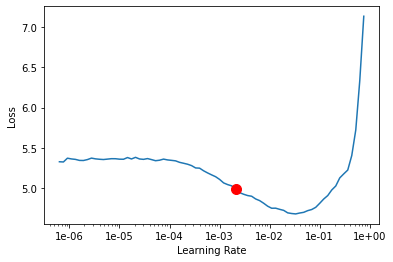

In [15]:
#lets find the correct learning rate to be used from lr finder
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [16]:
min_grad_lr = learn.recorder.min_grad_lr
min_grad_lr

0.0020892961308540407

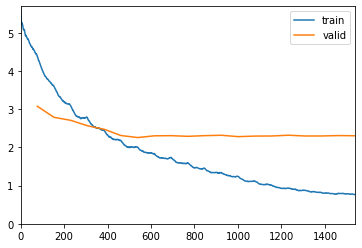

In [17]:
learn.fit_one_cycle(20,slice(min_grad_lr))

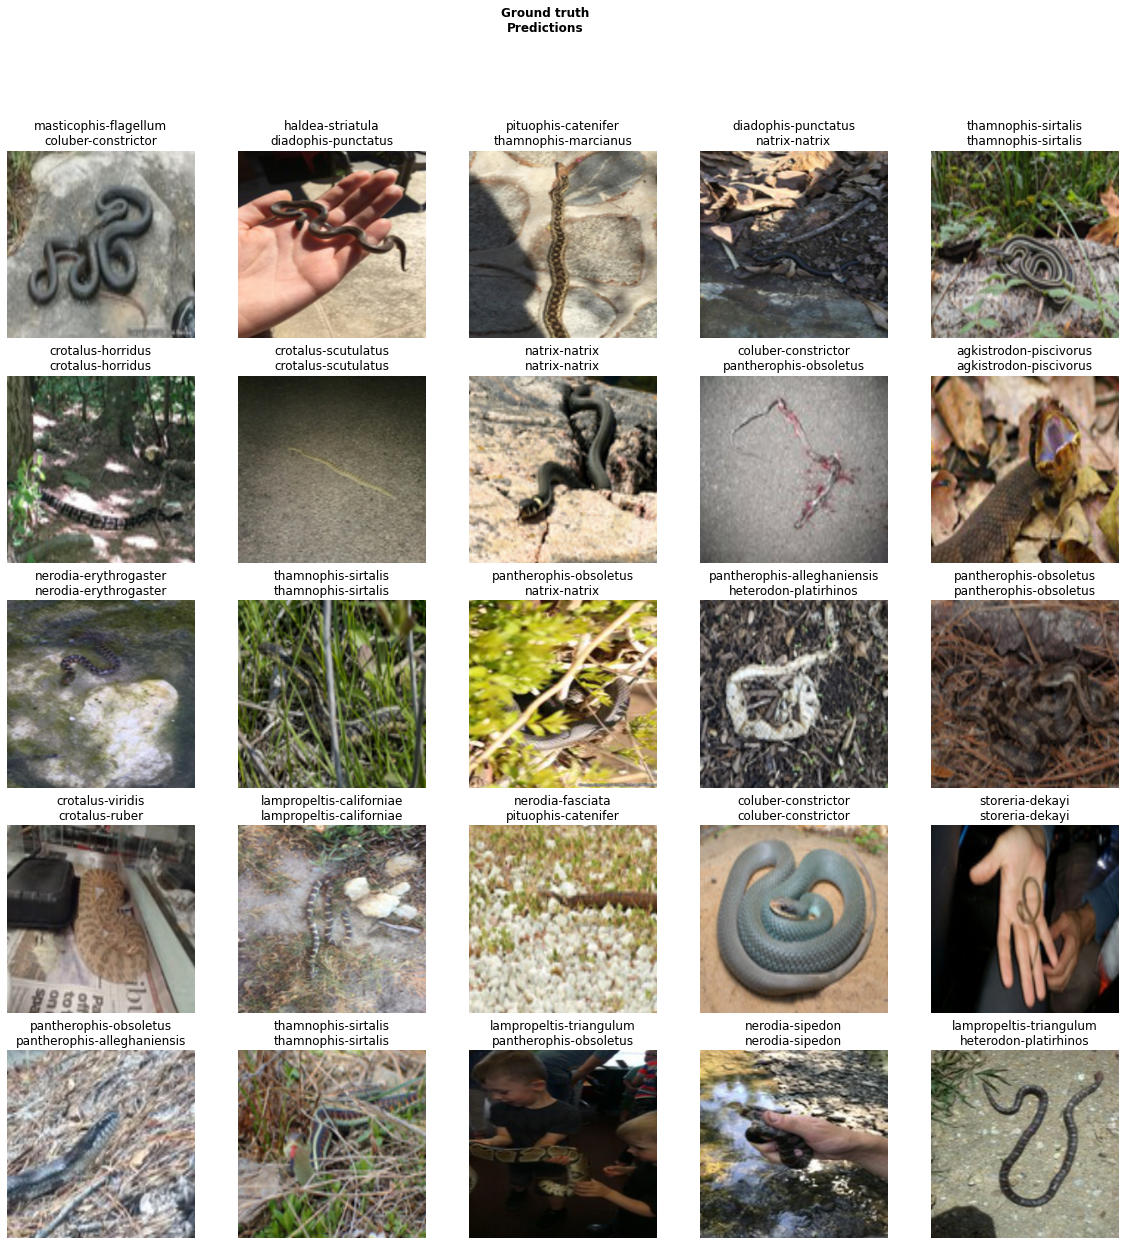

In [18]:
learn.show_results()

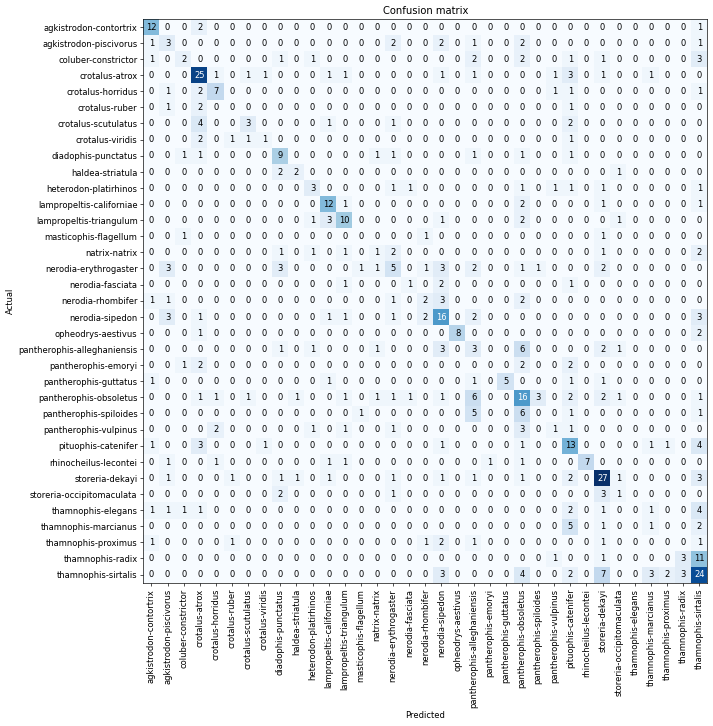

In [19]:
#lets see the most mis-classified images (on validation set)
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12),dpi=60)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.10E-04
Min loss divided by 10: 9.12E-08


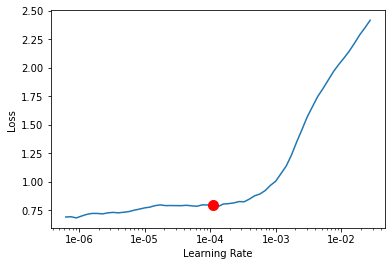

In [20]:
#lets plot the lr finder record
learn.unfreeze()
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [21]:
min_grad_lr = learn.recorder.min_grad_lr
min_grad_lr

0.00010964781961431851

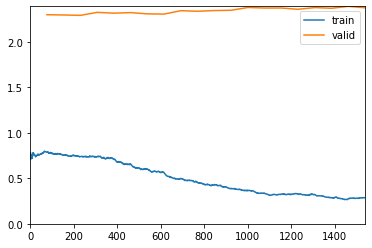

In [22]:
learn.fit_one_cycle(20,slice(min_grad_lr))

In [23]:
unfrozen_validation = learn.validate()
print("Final model validation loss: {0}".format(unfrozen_validation[0]))

Final model validation loss: 2.3761119842529297


In [24]:
learn.save('densenet201-unfrozen', return_path=True)

PosixPath('models/densenet201-unfrozen.pth')

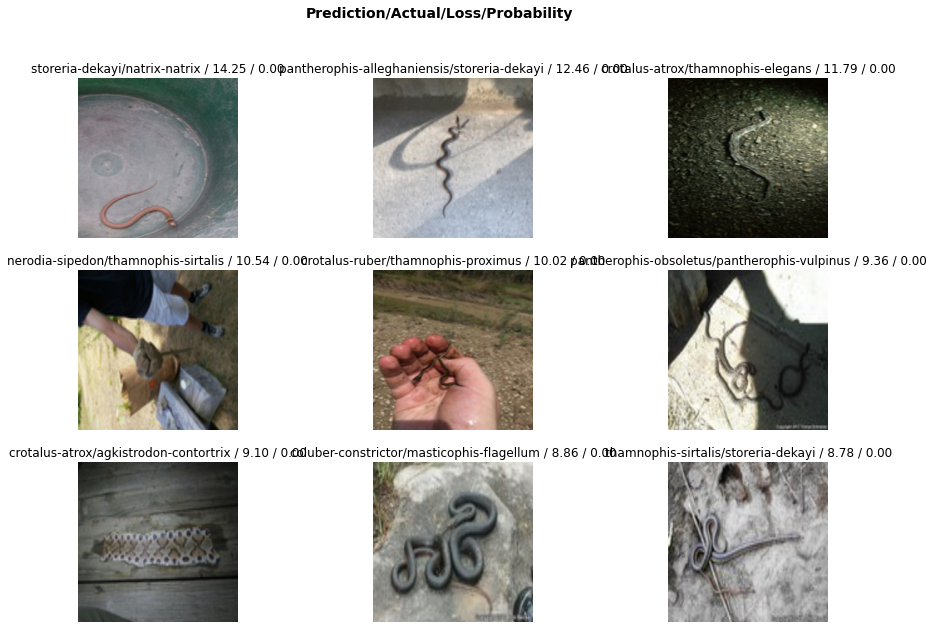

In [25]:
#lets see the most mis-classified images (on validation set)
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_top_losses(9, figsize=(15,10))

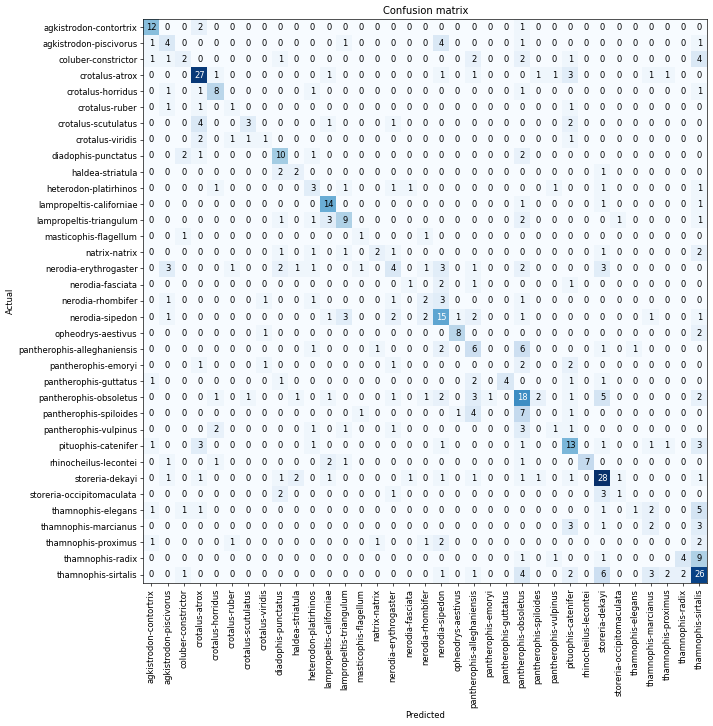

In [26]:
interp.plot_confusion_matrix(figsize=(12,12),dpi=60)

**TTA prediction return probabilities, not the last activations (because they took the average of the probabilities with different data augmentation)**,

In [27]:
##learn.TTA improves score further. lets see for the validation set
pred_val,y = learn.TTA(ds_type=DatasetType.Valid)
from sklearn.metrics import f1_score, accuracy_score
valid_preds = [np.argmax(pred_val[i])+1 for i in range(len(pred_val))]
valid_preds = np.array(valid_preds)
y = np.array(y+1)
accuracy_score(valid_preds,y),f1_score(valid_preds,y, average='weighted')

(0.45636363636363636, 0.48275316782892475)

In [28]:
preds,_ = learn.TTA(ds_type=DatasetType.Test)
#preds,_ = learn.get_preds(ds_type = DatasetType.Test)
labelled_preds = [np.argmax(preds[i])+1 for i in range(len(preds))]

labelled_preds = np.array(labelled_preds)

In [29]:
test.head()

image_id
0  7ede553357.jpg
1  3500b219e4.jpg
2  d43a78d6d9.jpg
3  1f36f26994.jpg
4  8cb85fc58e.jpg

In [30]:
df = pd.DataFrame({'image_id':test['image_id'], 'breed':labelled_preds})
df

image_id  breed
0     7ede553357.jpg     15
1     3500b219e4.jpg      2
2     d43a78d6d9.jpg      5
3     1f36f26994.jpg     29
4     8cb85fc58e.jpg     27
...              ...    ...
2356  93e591cb23.jpg     21
2357  68a603b39d.jpg     24
2358  4f472510f3.jpg     27
2359  d6884444ae.jpg     11
2360  c0fa7df5de.jpg     24

[2361 rows x 2 columns]

In [31]:
df.breed.max(),df.breed.min()

(35, 1)

In [32]:
label_dict ={}
for i ,item in enumerate(data.classes):
  label_dict[i+1] =item

In [33]:
label_dict

{1: 'agkistrodon-contortrix',
 2: 'agkistrodon-piscivorus',
 3: 'coluber-constrictor',
 4: 'crotalus-atrox',
 5: 'crotalus-horridus',
 6: 'crotalus-ruber',
 7: 'crotalus-scutulatus',
 8: 'crotalus-viridis',
 9: 'diadophis-punctatus',
 10: 'haldea-striatula',
 11: 'heterodon-platirhinos',
 12: 'lampropeltis-californiae',
 13: 'lampropeltis-triangulum',
 14: 'masticophis-flagellum',
 15: 'natrix-natrix',
 16: 'nerodia-erythrogaster',
 17: 'nerodia-fasciata',
 18: 'nerodia-rhombifer',
 19: 'nerodia-sipedon',
 20: 'opheodrys-aestivus',
 21: 'pantherophis-alleghaniensis',
 22: 'pantherophis-emoryi',
 23: 'pantherophis-guttatus',
 24: 'pantherophis-obsoletus',
 25: 'pantherophis-spiloides',
 26: 'pantherophis-vulpinus',
 27: 'pituophis-catenifer',
 28: 'rhinocheilus-lecontei',
 29: 'storeria-dekayi',
 30: 'storeria-occipitomaculata',
 31: 'thamnophis-elegans',
 32: 'thamnophis-marcianus',
 33: 'thamnophis-proximus',
 34: 'thamnophis-radix',
 35: 'thamnophis-sirtalis'}

In [34]:
def map_func(x):
  return label_dict[x]

In [35]:
label_dict[13]

'lampropeltis-triangulum'

In [36]:
df['breed'] = df['breed'].apply(lambda x:map_func(x))
df.head()

image_id                   breed
0  7ede553357.jpg           natrix-natrix
1  3500b219e4.jpg  agkistrodon-piscivorus
2  d43a78d6d9.jpg       crotalus-horridus
3  1f36f26994.jpg         storeria-dekayi
4  8cb85fc58e.jpg     pituophis-catenifer

In [110]:
df[df['image_id']=="aa16a509cf.jpg"]

image_id                breed
262  aa16a509cf.jpg  thamnophis-sirtalis

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


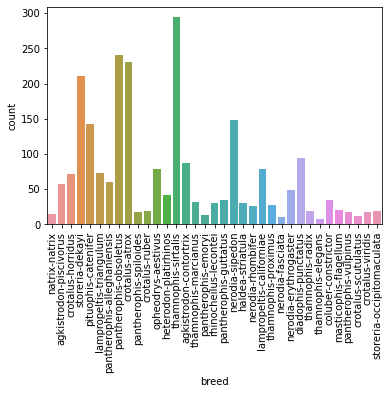

In [37]:
import seaborn as sns
sns.countplot(df['breed'])
plt.xticks(rotation=90)
plt.show()

In [38]:
df.isnull().sum()

image_id    0
breed       0
dtype: int64

In [39]:
def remove_jpg(x):
  return x.split(".")[0]

In [40]:
df['image_id'] = df['image_id'].apply(lambda x: remove_jpg(x))

In [42]:
df.head()

image_id                   breed
0  7ede553357           natrix-natrix
1  3500b219e4  agkistrodon-piscivorus
2  d43a78d6d9       crotalus-horridus
3  1f36f26994         storeria-dekayi
4  8cb85fc58e     pituophis-catenifer

In [43]:
df.to_csv("densenet101.csv",index=False)

#### **Resnet101 score 44.20773**

#### **Densenet201 score 41.03245**

#### **Resnet50 score 38.60842**

#### **Resnet34 score 42.94714**

#### **eficientnet3b score 35.84280**

# Keras- Transfer Learning - EfficientNet



In [ ]:
import numpy as np
import pandas as pd
#
import random, os
#
import cv2
#
import matplotlib.pyplot as plt 
import seaborn as sns
import matplotlib.image as mpimg
%matplotlib inline
#
import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.optimizers import Adam

In [ ]:
labels = pd.read_csv("/content/drive/MyDrive/HackerEarth_deep_learning/snake_breed/train.csv")

labels.head() 
file_paths = [[fname, '/content/drive/MyDrive/HackerEarth_deep_learning/snake_breed/train/' + fname+".jpg"] for fname in labels['image_id']]

if len(labels) == len(file_paths):
  print('Number of labels i.e. ', len(labels), 'matches the number of filenames i.e. ', len(file_paths))
else:
  print('Number of labels does not match the number of filenames')

images = pd.DataFrame(file_paths, columns=['image_id', 'filepaths'])
images.head()


train_data = pd.merge(images, labels, how = 'inner', on = 'image_id')
train_data.head()

Number of labels i.e.  5508 matches the number of filenames i.e.  5508


image_id  ...                   breed
0  a8b3ad1dde  ...   nerodia-erythrogaster
1  8b492b973d  ...   pantherophis-vulpinus
2  929b99ea92  ...     thamnophis-sirtalis
3  bbac7385e2  ...  pantherophis-obsoletus
4  ef776b1488  ...  agkistrodon-contortrix

[5 rows x 3 columns]

In [ ]:
test_image_order = pd.read_csv("/content/drive/MyDrive/HackerEarth_deep_learning/snake_breed/test.csv")
test_image_order.head()

file_paths_test = [[fname, '/content/drive/MyDrive/HackerEarth_deep_learning/snake_breed/test/' + fname+".jpg"] for fname in test_image_order['image_id']]

test_images = pd.DataFrame(file_paths_test, columns=['image_id', 'filepaths'])
test_images.head()

image_id                                          filepaths
0  7ede553357  /content/drive/MyDrive/HackerEarth_deep_learni...
1  3500b219e4  /content/drive/MyDrive/HackerEarth_deep_learni...
2  d43a78d6d9  /content/drive/MyDrive/HackerEarth_deep_learni...
3  1f36f26994  /content/drive/MyDrive/HackerEarth_deep_learni...
4  8cb85fc58e  /content/drive/MyDrive/HackerEarth_deep_learni...

In [ ]:
train_data['image_id'] = train_data['image_id']+str('.jpg')
test_images['image_id'] = test_images['image_id']+str('.jpg')

In [ ]:
train_data.head()

image_id  ...                   breed
0  a8b3ad1dde.jpg  ...   nerodia-erythrogaster
1  8b492b973d.jpg  ...   pantherophis-vulpinus
2  929b99ea92.jpg  ...     thamnophis-sirtalis
3  bbac7385e2.jpg  ...  pantherophis-obsoletus
4  ef776b1488.jpg  ...  agkistrodon-contortrix

[5 rows x 3 columns]

In [ ]:
num_classes = len(train_data.breed.unique())
num_classes

35

**Converting Target (breed) into Numerical**

In [ ]:
train_data["breed"] = train_data["breed"].astype('category')
train_data.dtypes

image_id       object
filepaths      object
breed        category
dtype: object

In [ ]:
train_data["label"] = train_data["breed"].cat.codes
train_data.head()

image_id  ... label
0  a8b3ad1dde.jpg  ...    15
1  8b492b973d.jpg  ...    25
2  929b99ea92.jpg  ...    34
3  bbac7385e2.jpg  ...    23
4  ef776b1488.jpg  ...     0

[5 rows x 4 columns]

In [ ]:
# Check Categories.
LABEL = train_data["breed"].cat.categories
LABEL

Index(['agkistrodon-contortrix', 'agkistrodon-piscivorus',
       'coluber-constrictor', 'crotalus-atrox', 'crotalus-horridus',
       'crotalus-ruber', 'crotalus-scutulatus', 'crotalus-viridis',
       'diadophis-punctatus', 'haldea-striatula', 'heterodon-platirhinos',
       'lampropeltis-californiae', 'lampropeltis-triangulum',
       'masticophis-flagellum', 'natrix-natrix', 'nerodia-erythrogaster',
       'nerodia-fasciata', 'nerodia-rhombifer', 'nerodia-sipedon',
       'opheodrys-aestivus', 'pantherophis-alleghaniensis',
       'pantherophis-emoryi', 'pantherophis-guttatus',
       'pantherophis-obsoletus', 'pantherophis-spiloides',
       'pantherophis-vulpinus', 'pituophis-catenifer', 'rhinocheilus-lecontei',
       'storeria-dekayi', 'storeria-occipitomaculata', 'thamnophis-elegans',
       'thamnophis-marcianus', 'thamnophis-proximus', 'thamnophis-radix',
       'thamnophis-sirtalis'],
      dtype='object')

In [ ]:
LABEL[15], LABEL[25]

('nerodia-erythrogaster', 'pantherophis-vulpinus')

In [ ]:
train_data.breed.value_counts(normalize=True) * 100.0

thamnophis-sirtalis            9.241104
storeria-dekayi                7.480029
pantherophis-obsoletus         6.644880
crotalus-atrox                 6.427015
pituophis-catenifer            5.410312
nerodia-sipedon                4.702251
agkistrodon-contortrix         3.740015
lampropeltis-triangulum        3.576616
diadophis-punctatus            3.340595
pantherophis-alleghaniensis    3.122731
nerodia-erythrogaster          3.104575
lampropeltis-californiae       3.013798
opheodrys-aestivus             2.759622
agkistrodon-piscivorus         2.668845
crotalus-horridus              2.578068
coluber-constrictor            2.342048
heterodon-platirhinos          2.142338
thamnophis-proximus            2.033406
nerodia-rhombifer              1.888163
pantherophis-guttatus          1.815541
thamnophis-radix               1.815541
haldea-striatula               1.779230
pantherophis-spiloides         1.670298
rhinocheilus-lecontei          1.652142
storeria-occipitomaculata      1.579521


In [ ]:
train_data.label.value_counts(normalize=True) * 100.0

34    9.241104
28    7.480029
23    6.644880
3     6.427015
26    5.410312
18    4.702251
0     3.740015
12    3.576616
8     3.340595
20    3.122731
15    3.104575
11    3.013798
19    2.759622
1     2.668845
4     2.578068
2     2.342048
10    2.142338
32    2.033406
17    1.888163
33    1.815541
22    1.815541
9     1.779230
24    1.670298
27    1.652142
29    1.579521
13    1.506899
7     1.506899
31    1.488744
5     1.397967
16    1.343500
25    1.325345
14    1.307190
30    1.252723
21    1.198257
6     1.143791
Name: label, dtype: float64

In [ ]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5508 entries, 0 to 5507
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   image_id   5508 non-null   object  
 1   filepaths  5508 non-null   object  
 2   breed      5508 non-null   category
 3   label      5508 non-null   int8    
dtypes: category(1), int8(1), object(2)
memory usage: 141.4+ KB


**Training the Model**

In [ ]:
# Main parameters
BATCH_SIZE = 32
STEPS_PER_EPOCH = len(train_data)*0.8 / BATCH_SIZE
VALIDATION_STEPS = len(train_data)*0.2 / BATCH_SIZE
EPOCHS = 20
TARGET_SIZE = 224

In [ ]:
train_img_dir = "/content/drive/MyDrive/HackerEarth_deep_learning/snake_breed/train"
test_img_dir = "/content/drive/MyDrive/HackerEarth_deep_learning/snake_breed/test"

In [ ]:
train_data.label = train_data.label.astype('str')
train_data.head()

image_id  ... label
0  a8b3ad1dde.jpg  ...    15
1  8b492b973d.jpg  ...    25
2  929b99ea92.jpg  ...    34
3  bbac7385e2.jpg  ...    23
4  ef776b1488.jpg  ...     0

[5 rows x 4 columns]

In [ ]:
train_datagen = ImageDataGenerator(
    validation_split = 0.2,
    preprocessing_function = None,
    rotation_range = 20,
    zoom_range = 0.2,
    cval = 0.1,
    horizontal_flip = True,
    vertical_flip = True,
    fill_mode = 'nearest',
    shear_range = 0.15,
    height_shift_range = 0.15,
    width_shift_range = 0.15,
    featurewise_center = True,
    featurewise_std_normalization = True
)

train_generator = train_datagen.flow_from_dataframe(
    train_data,
    directory = train_img_dir,
    subset = "training",
    x_col = "image_id",
    y_col = "label",
    target_size = (TARGET_SIZE, TARGET_SIZE),
    batch_size = BATCH_SIZE,
    class_mode = "sparse"
)

Found 4407 validated image filenames belonging to 35 classes.


In [ ]:
validation_datagen = ImageDataGenerator(validation_split = 0.2)

validation_generator = validation_datagen.flow_from_dataframe(
    train_data,
    directory = train_img_dir,
    subset = "validation",
    x_col = "image_id",
    y_col = "label",
    target_size = (TARGET_SIZE, TARGET_SIZE),
    batch_size = BATCH_SIZE,
    class_mode = "sparse"
)

Found 1101 validated image filenames belonging to 35 classes.


In [ ]:
import keras.backend as K

def get_f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [ ]:
conv_base = EfficientNetB0(
    include_top = False, 
    weights = 'imagenet',
    input_shape = (224, 224, 3)
)

model = conv_base.output
model = layers.GlobalAveragePooling2D()(model)
model = layers.Dense(128,activation='relu')(model)
model = layers.Dropout(0.2)(model)
model = layers.Dense(35, activation = "softmax")(model)
model = models.Model(conv_base.input, model)
#
for layer in model.layers[-20:]:
        if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True
#
model.compile(
    optimizer = Adam(lr = 0.001),
    loss = "sparse_categorical_crossentropy",
    metrics = ["accuracy",get_f1]
)

model.summary()

Model: "functional_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
rescaling_5 (Rescaling)         (None, 224, 224, 3)  0           input_6[0][0]                    
__________________________________________________________________________________________________
normalization_5 (Normalization) (None, 224, 224, 3)  7           rescaling_5[0][0]                
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 225, 225, 3)  0           normalization_5[0][0]            
______________________________________________________________________________________

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
cbs = [tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=1, min_lr=1e-5, verbose=0),
           tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-6, patience=10, verbose=1, mode='auto')]

In [ ]:
history = model.fit(
    train_generator,
    steps_per_epoch = STEPS_PER_EPOCH,
    epochs = 50,
    validation_data = validation_generator,
    validation_steps = VALIDATION_STEPS,
    callbacks = [cbs]
)

Epoch 1/50
138/137 [==============================] - 71s 518ms/step - loss: 3.0536 - accuracy: 0.1913 - get_f1: 19.2722 - val_loss: 3.6666 - val_accuracy: 0.1726 - val_get_f1: 8.3036
Epoch 2/50
138/137 [==============================] - 70s 508ms/step - loss: 2.5928 - accuracy: 0.2818 - get_f1: 13.1403 - val_loss: 2.9186 - val_accuracy: 0.2788 - val_get_f1: 7.0461
Epoch 3/50
138/137 [==============================] - 70s 505ms/step - loss: 2.3516 - accuracy: 0.3431 - get_f1: 11.0739 - val_loss: 2.5057 - val_accuracy: 0.2770 - val_get_f1: 10.8148
Epoch 4/50
138/137 [==============================] - 70s 505ms/step - loss: 2.1846 - accuracy: 0.3771 - get_f1: 9.9286 - val_loss: 2.4871 - val_accuracy: 0.3188 - val_get_f1: 9.5743
Epoch 5/50
138/137 [==============================] - 70s 505ms/step - loss: 2.0664 - accuracy: 0.4066 - get_f1: 8.8985 - val_loss: 2.7086 - val_accuracy: 0.3034 - val_get_f1: 8.3676
Epoch 6/50
138/137 [==============================] - 70s 506ms/step - loss: 1.65

# Visualize the Performance

In [ ]:
import matplotlib as mpl
COLOR = 'orange'
mpl.rcParams['text.color'] = COLOR
mpl.rcParams['axes.labelcolor'] = COLOR
mpl.rcParams['xtick.color'] = COLOR
mpl.rcParams['ytick.color'] = COLOR

In [ ]:
SMALL_SIZE = 10
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

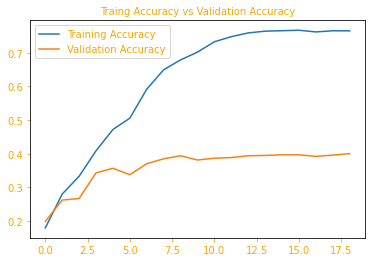

In [ ]:
plt.plot(history.history['accuracy'],label='Training Accuracy')
plt.plot(history.history['val_accuracy'],label='Validation Accuracy')
plt.legend()
plt.title("Traing Accuracy vs Validation Accuracy")
plt.show()

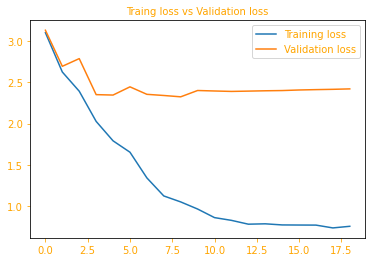

In [ ]:
plt.plot(history.history['loss'],label='Training loss')
plt.plot(history.history['val_loss'],label='Validation loss')
plt.legend()
plt.title("Traing loss vs Validation loss")
plt.show()

In [ ]:
# example of saving an image with the Keras API
from keras.preprocessing.image import load_img
from keras.preprocessing.image import save_img
from keras.preprocessing.image import img_to_array
import os

In [ ]:
test_images.head()

image_id                                          filepaths
0  7ede553357.jpg  /content/drive/MyDrive/HackerEarth_deep_learni...
1  3500b219e4.jpg  /content/drive/MyDrive/HackerEarth_deep_learni...
2  d43a78d6d9.jpg  /content/drive/MyDrive/HackerEarth_deep_learni...
3  1f36f26994.jpg  /content/drive/MyDrive/HackerEarth_deep_learni...
4  8cb85fc58e.jpg  /content/drive/MyDrive/HackerEarth_deep_learni...

In [ ]:
imgtst  = test_images['filepaths'].values.tolist()

In [ ]:
test_pixel_data = []
for i in range(len(test_images)):

  img_array = cv2.imread(test_images['filepaths'][i], cv2.COLOR_BGR2RGB) 

  new_img_array = cv2.resize(img_array, (224,224))
  #new_img_array = cv2.GaussianBlur(new_img_array,(5,5),0)
  test_pixel_data.append(new_img_array)


In [ ]:
test_pixel_data = np.array(test_pixel_data)

test_pixel_data = test_pixel_data/255.0

In [ ]:
test_pixel_data.shape

(2361, 224, 224, 3)

In [ ]:
preds = model.predict(test_pixel_data)

In [ ]:
np.argsort(preds[1])

array([20, 31,  4, 30, 18, 29, 25, 15, 17,  2, 16, 32, 27, 14, 12,  6,  1,
        0,  3,  9, 26, 24, 23, 22, 19,  8, 34, 10, 33, 11, 13,  7,  5, 21,
       28])

# EfficientNetB5

In [ ]:
!pip install keras_efficientnets

In [ ]:
!git clone https://github.com/Tony607/efficientnet_keras_transfer_learning
%cd efficientnet_keras_transfer_learning/

fatal: destination path 'efficientnet_keras_transfer_learning' already exists and is not an empty directory.
/content/efficientnet_keras_transfer_learning


In [ ]:
from efficientnet import EfficientNetB0 
from efficientnet import center_crop_and_resize, preprocess_input

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB5
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam,SGD
from tensorflow.keras.regularizers import  l1_l2

In [ ]:
def build_model():
    model = models.Sequential()
    
    conv_base = EfficientNetB5(input_shape=(224,224,3), include_top=False, pooling='max',weights='imagenet')
    model.add(conv_base)
    model.add(Flatten())
    model.add(Dense(1024,activation=('relu'),input_dim=512))
    model.add(Dense(512,activation=('relu'))) 
    model.add(Dense(256,activation=('relu'))) 
    #model.add(Dropout(.3))
    model.add(Dense(128,activation=('relu')))
    #model.add(Dropout(.2))
    model.add(Dense(10,activation=('softmax'))) 
  

    model.compile(loss='categorical_crossentropy', optimizer=SGD(lr=0.001,momentum=.9,nesterov=False), metrics=['accuracy',get_f1])
    
    return model

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb5 (Functional)  (None, 2048)              28513527  
_________________________________________________________________
batch_normalization_3 (Batch (None, 2048)              8192      
_________________________________________________________________
dense_2 (Dense)              (None, 2048)              4196352   
_________________________________________________________________
batch_normalization_4 (Batch (None, 2048)              8192      
_________________________________________________________________
dense_3 (Dense)              (None, 35)                71715     
Total params: 32,797,978
Trainable params: 32,617,043
Non-trainable params: 180,935
_________________________________________________________________


In [ ]:
model = build_model()
#Checking the final model summary
model.summary()

Training 

In [ ]:
EPOCHS =15
BS =8
history = model.fit(
	train_generator,
	steps_per_epoch=len(X_train) // BS,
	validation_data=val_generator,
	validation_steps=len(X_val) // BS,
	epochs=EPOCHS)

Epoch 1/15
